In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/Projects/bind_RBM`


In [2]:
using CairoMakie
using RestrictedBoltzmannMachines: sample_from_inputs, inputs_h_from_v, mean_from_inputs
using DelimitedFiles, LinearAlgebra, Statistics, Random
using RestrictedBoltzmannMachines: RBM, Potts, Binary, ReLU, nsReLU, log_pseudolikelihood, initialize!, pcd!,
             sample_v_from_v, free_energy, onehot_encode, sample_h_from_v
using Statistics: mean, cov, std, var, cor
using LinearAlgebra: norm
const ALPHABET = "ACDEFGHIKLMNPQRSTVWY-"
alphabet_dict = Dict(c => i for (i, c) in enumerate(ALPHABET))
split_idx = 81
using JLD2
using MultivariateStats
using MLJ, MLJLinearModels
using Random: MersenneTwister, shuffle, bitrand
using DataFrames
using Logging
using SequenceLogos
using XLSX
alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")
using bind_RBM: plot_model_vs_data, create_binding_dictionary_Gogl, create_binding_dictionary, score_strings, parse_rules_file, best_strings_per_class, collect_key_label_hits_per_class, onehot_encode_2d,
                plot_matrix_logo

In [3]:
data_Gogl = create_binding_dictionary_Gogl("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022.xlsx", "/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022_final.xlsx", 4)
data_Stiffler = create_binding_dictionary("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/output.txt")


Skipped rows: 2037


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 84 entries:
  "----------GFGIAISGGRDNP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------SLGLSIAGGVGSP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------PWGFRLQGGKDFN… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------FLGISIVGQSNER… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GFGLTVSG--DN-… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGLSIVGKRSGS… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-----KKDSEGFGFVLRGAKAQT… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSILDYQDPI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VKLFK-NSSGLGFSFSREDNLI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGF

In [4]:
function unique_elements_from_dict(d::Dict)
    uniq = Set{String}()
    for v in values(d)
        union!(uniq, v.elements)
    end
    return uniq
end

uniq_Gogl     = unique_elements_from_dict(data_Gogl)
uniq_Stiffler = unique_elements_from_dict(data_Stiffler)

common = intersect(uniq_Gogl, uniq_Stiffler)
n_common = length(common)

println("Unique elements in common: ", n_common)

function filter_dict_by_elements(d::Dict, common_elements::Set{String})
    out = Dict{eltype(keys(d)), eltype(values(d))}()

    for (k, v) in d
        filtered = [e for e in v.elements if e in common_elements]

        if !isempty(filtered)
            # reconstruct named tuple, replacing only `elements`
            out[k] = merge(v, (elements = filtered,))
        end
    end

    return out
end


filtered_Gogl     = filter_dict_by_elements(data_Gogl, common)
filtered_Stiffler = filter_dict_by_elements(data_Stiffler, common)

union_dict = merge(filtered_Gogl, filtered_Stiffler)
union_tot = merge(data_Gogl, data_Stiffler)

Unique elements in common: 53


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 338 entries:
  "-------GPAPWGFRLQGGKDFN… => (elements = ["DTLEKFVEGL", "RRSQSRESQC", "SSRTRR…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VTLEK-MSAGLGFSLEGGKGSL… => (elements = ["SKSLERATQL", "LLQEEWETVM", "THREVK…
  "-----------------------… => (elements = ["DTLEKFVEGL", "RRSQSRESQC", "SSRTRR…
  "-VELTK-NVQGLGITIAGYIGDK… => (elements = ["SSIDLWETAL", "STLTIFETAL", "DTLEKF…
  "-------DGGPLGIHVVPFSARG… => (elements = ["EPTTTTSVPL", "SSEGVPDLLV", "DTLEKF…
  "-----TVSGNGLGIRIVGGKEIP… => (elements = ["RSLEEEESQL", "EMDRRPATVV", "DPRNTQ…
  "-------KNPGLGFSISGGISGQ… => (elements = ["HYPASPDSWV", "QYPGSPDSWV", "PLPPEE…
  "-IELEK-GSKGLGFSILDYQDPI… => (elements = ["SVISRREWYV", "QKNKDREYYV", "GDSSRK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VTLKRDPHRGFGFVINEGEYSG… => (elements = ["LHLHGTGIQV", "SVISRREWYV", "DSATVR…
  "-VVLTADPVTGFG

In [14]:
# Or flatten into a single vector of all elements
all_elements_flat = vcat([value.elements for value in values(union_dict)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_common = score_strings(file_content, all_elements_flat)


Dict{String, Vector{Float64}} with 53 entries:
  "RSSGGDDFWF" => [0.0, 0.2, 0.2, 0.666667, 0.75, 1.0, 0.166667, 0.4, 0.166667,…
  "DSEEELPTRL" => [0.0, 0.0, 0.2, 0.166667, 0.25, 0.25, 0.166667, 0.0, 0.5, 0.6…
  "PDSNPEESSV" => [0.4, 0.2, 0.2, 0.333333, 0.25, 0.5, 0.166667, 0.0, 0.5, 0.2,…
  "EFKQTSSFLV" => [0.2, 0.4, 0.4, 0.5, 0.75, 0.5, 0.333333, 0.0, 0.166667, 0.0,…
  "SRPRPDDLEI" => [0.0, 0.0, 0.4, 0.5, 0.5, 0.75, 0.166667, 0.0, 0.166667, 0.0,…
  "NKSEPFLTWL" => [0.0, 0.0, 0.2, 0.333333, 0.75, 0.5, 0.5, 0.6, 0.333333, 0.6,…
  "KPDKQEEFYA" => [0.0, 0.2, 0.2, 0.5, 0.5, 0.75, 0.0, 0.0, 0.166667, 0.2, 0.33…
  "RQKEVRESKC" => [0.6, 0.0, 0.0, 0.333333, 0.0, 0.25, 0.0, 0.0, 0.5, 0.4, 0.33…
  "KKNKDKEYYV" => [0.4, 0.2, 0.4, 0.666667, 0.75, 1.0, 0.166667, 0.0, 0.5, 0.2,…
  "ASGLDKRDYV" => [0.4, 0.2, 0.2, 0.5, 0.5, 0.5, 0.333333, 0.0, 0.333333, 0.0, …
  "AHGSTRDQSI" => [0.2, 0.0, 0.2, 0.333333, 0.25, 0.5, 0.166667, 0.0, 0.5, 0.0,…
  "DTKNYKQTSV" => [0.6, 0.2, 0.2, 0.333333, 0.25, 0.25, 0.1666

In [4]:
using CairoMakie

function plot_histograms(results)
    all_scores = collect(values(results))
    n_classes = length(all_scores[1])
    
    fig = Figure(resolution = (1200, 1000))
    
    for i in 1:n_classes
        row = div(i - 1, 4) + 1
        col = mod(i - 1, 4) + 1
        
        class_scores = [scores[i] for scores in all_scores]
        
        ax = Axis(fig[row, col], xlabel = "Score", ylabel = "Count", title = "CLASS $i")
        hist!(ax, class_scores, bins = 20, color = (:blue, 0.5))
    end
    
    fig
end

plot_histograms (generic function with 1 method)

In [7]:
# Or flatten into a single vector of all elements
all_elements_union = vcat([value.elements for value in values(union_tot)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_full = score_strings(file_content, all_elements_union)
plot_histograms(peptides_full)

LoadError: UndefVarError: `union_tot` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


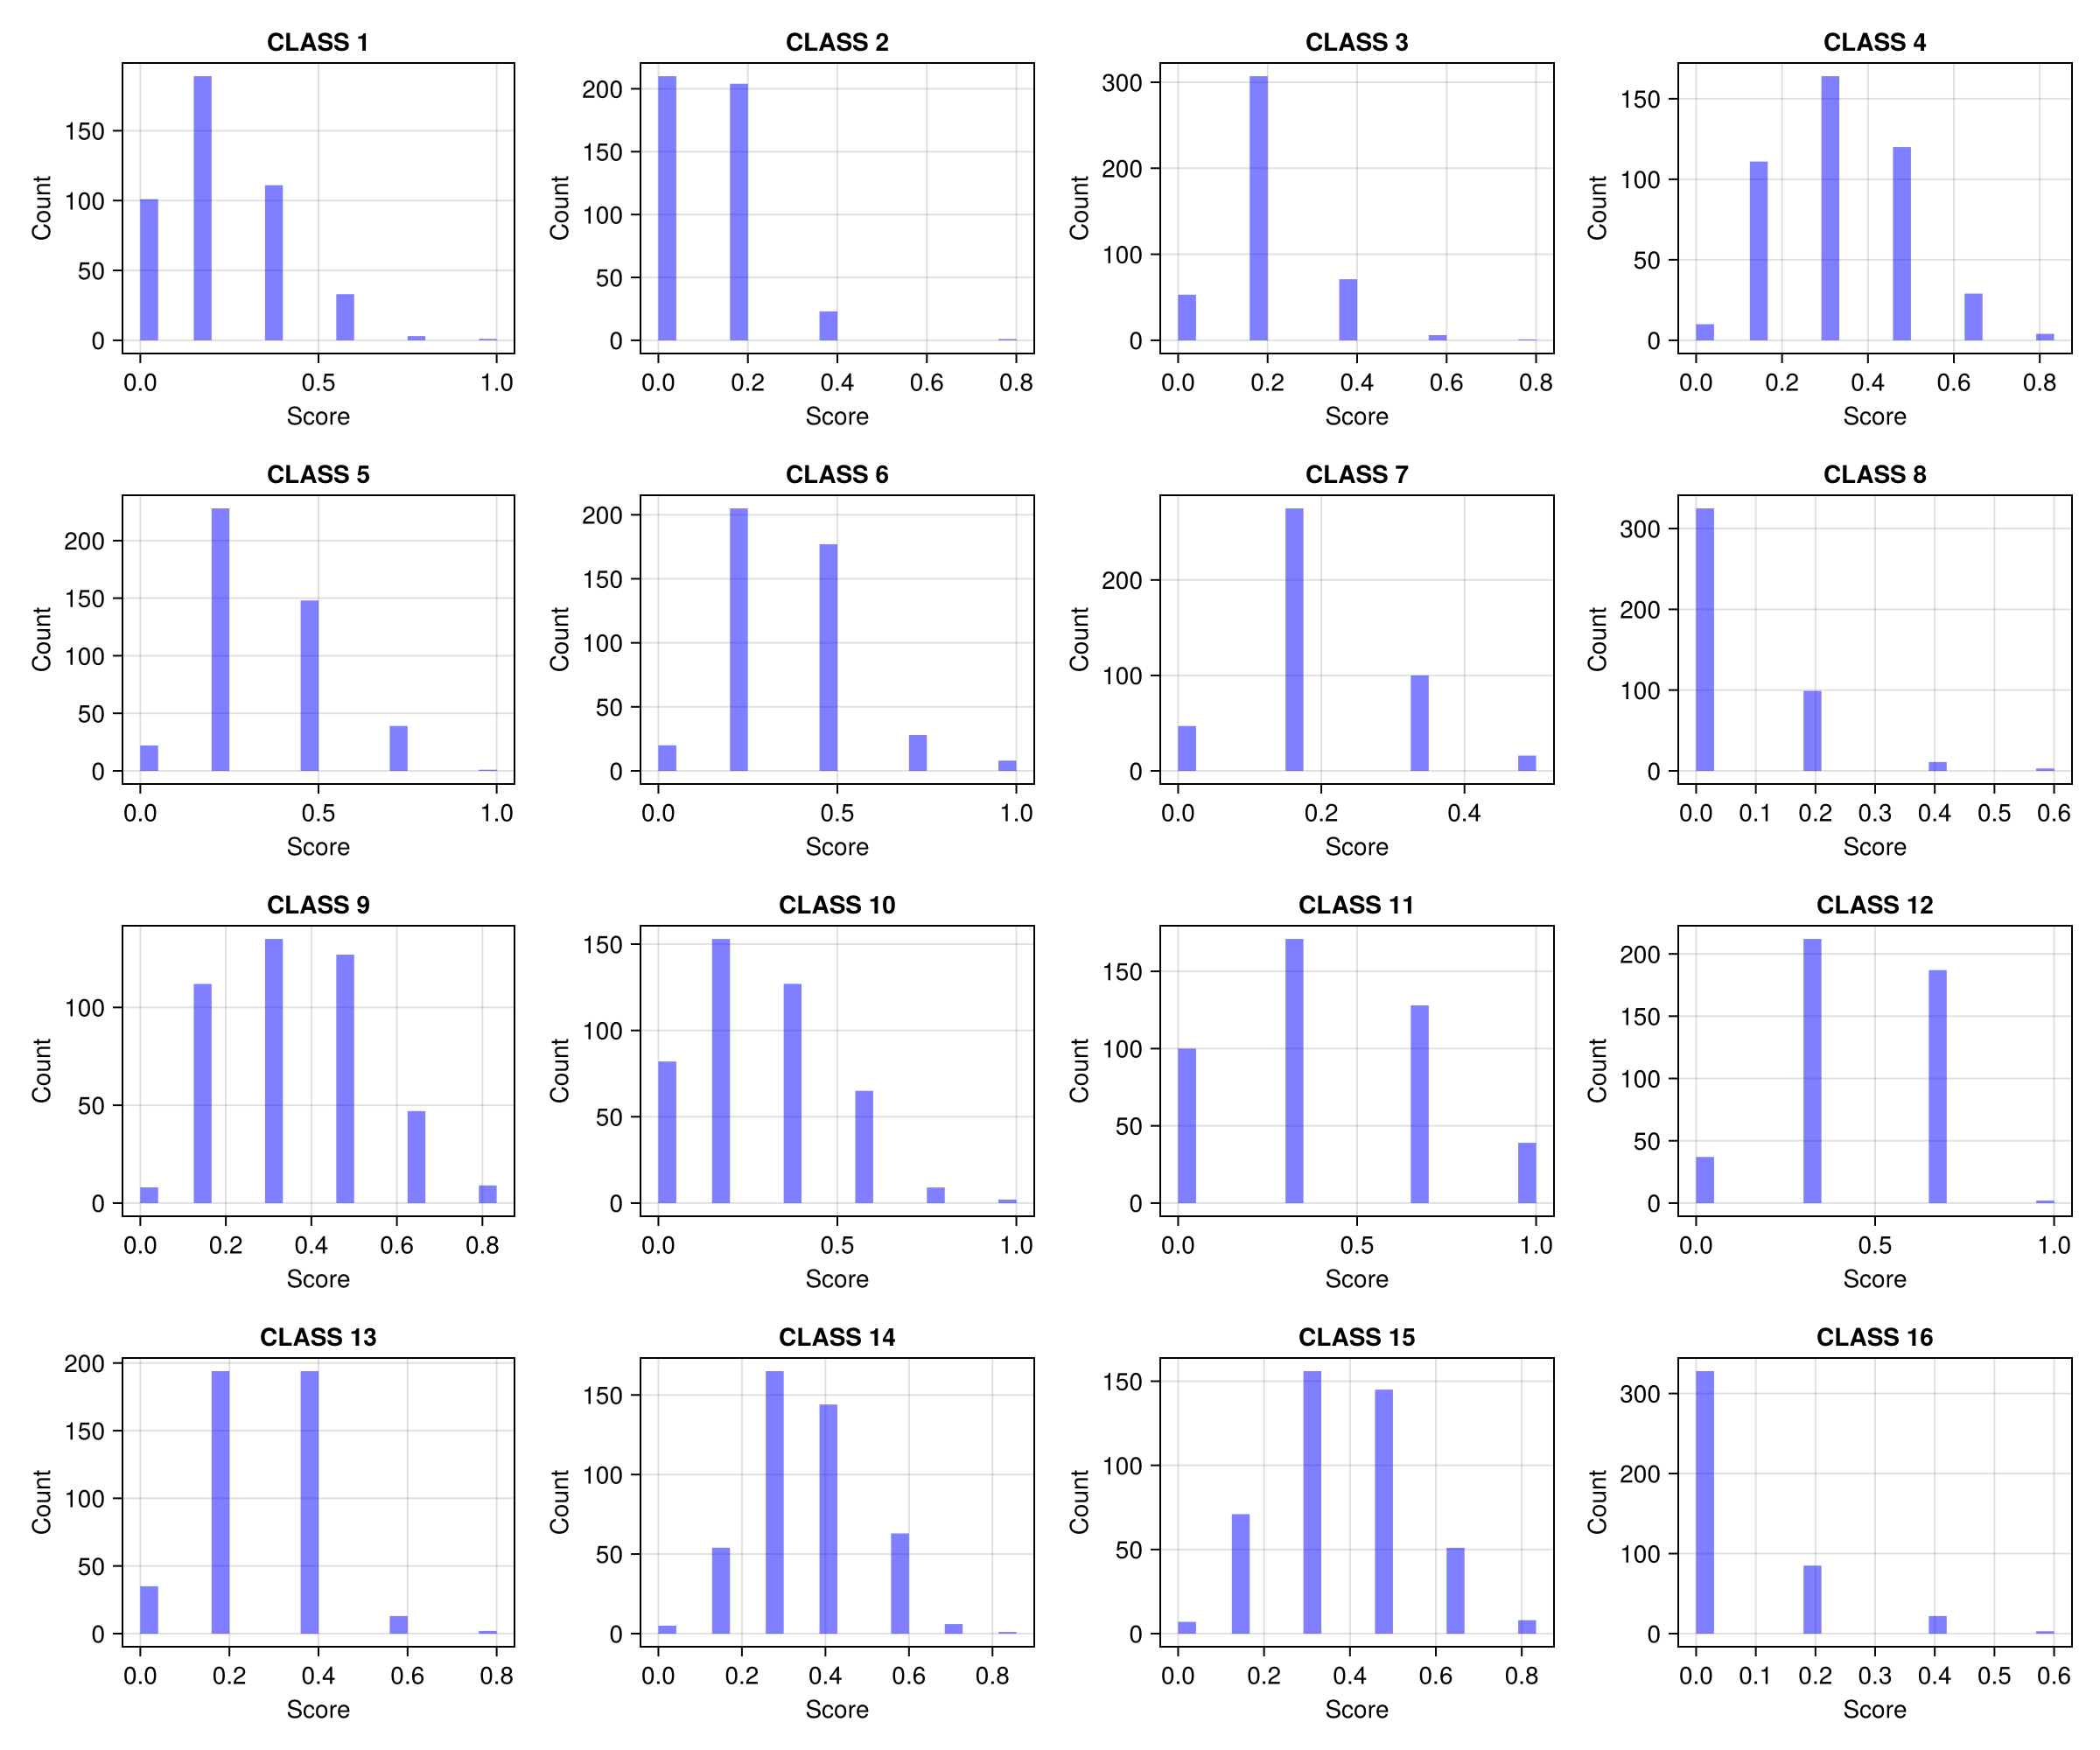

In [5]:
# Or flatten into a single vector of all elements
all_elements_Gogl = vcat([value.elements for value in values(data_Gogl)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_full = score_strings(file_content, all_elements_Gogl)
plot_histograms(peptides_full)

In [6]:
dict = best_strings_per_class(file_content, all_elements_Gogl)
indexed, by_class = collect_key_label_hits_per_class(dict, data_Gogl)


((class_names = ["#CLASS 1", "#CLASS 10", "#CLASS 11", "#CLASS 12", "#CLASS 13", "#CLASS 14", "#CLASS 15", "#CLASS 16", "#CLASS 2", "#CLASS 3", "#CLASS 4", "#CLASS 5", "#CLASS 6", "#CLASS 7", "#CLASS 8", "#CLASS 9"], class_to_idx = Dict("#CLASS 5" => 12, "#CLASS 12" => 4, "#CLASS 9" => 16, "#CLASS 11" => 3, "#CLASS 16" => 8, "#CLASS 2" => 9, "#CLASS 13" => 5, "#CLASS 15" => 7, "#CLASS 14" => 6, "#CLASS 10" => 2…), keys_by_class = [["-VTLEK-MSAGLGFSLEGGKGSLDKPLTINRIFKGAASEQSEVQPGDEILQLGGTAMQGLTRFEAWNIIKALPDPVTIVI-", "-----TVSGNGLGIRIVGGKEIPEIGAYIAKILPGGSAEQTGLMEGMQVLEWNGIPLTSKTYEEVQSIISQQSGEI-----", "-------KNPGLGFSISGGISGQDKGIFVTRVQPDGPASNL-LQPGDKILQANGHSFVHMEHEKAVLLLKSFQNTVDLVIQ", "-IELEK-GSKGLGFSILDYQDPISTVIIIRSLVPGGIAEKDGLLPGDRLMFVNDVNLENSSLEEAVEALKGAPSTVRIGV-", "-VTLKRDPHRGFGFVINEGEYSGDPGIFISSIIPGGPAEKAKIKPGGQILALNHISLEGFTFNMAVRMIQNSPDNIELII-", "-VVLTADPVTGFGIQLQGSVFATSSPPLISYIEADSPAERCGLQIGDRVMAINGIPTEDSTFEEASQLLRDSSIKVTLEIE", "--QIDLQGPGPWGFRLVGGKDFE-QPLAISRVTPGKAALAN-LCIGDVITAID

In [7]:
using LinearAlgebra
using Optim

@inline sigmoid(z) = 1 / (1 + exp(-z))

"""
Train one highly-regularized binary logistic regression per class.

Assumptions (checked):
- labels are exactly 0/1
- keys within each class all have same length (required by onehot_encode_2d)
- all characters in keys exist in char_to_index

Returns:
- models_by_class::Dict{String, NamedTuple}  # (w,b,status,optim)
- pack::NamedTuple                           # aligned vector of models + indexing
"""
function train_binary_models_per_class_01(indexed::NamedTuple,
                                          alphabet::Vector{Char},
                                          char_to_index::Dict{Char,Int};
                                          λ::Float64 = 300.0,
                                          maxiters::Int = 300)

    class_names     = indexed.class_names
    class_to_idx    = indexed.class_to_idx
    keys_by_class   = indexed.keys_by_class
    labels_by_class = indexed.labels_by_class

    models_vec = Vector{Any}(undef, length(class_names))
    models_by_class = Dict{String, Any}()

    opts = Optim.Options(iterations = maxiters)

    for i in eachindex(class_names)
        cname = class_names[i]
        keys  = keys_by_class[i]
        yint  = labels_by_class[i]

        if isempty(keys)
            m = (status=:empty,)
            models_vec[i] = m
            models_by_class[cname] = m
            continue
        end

        # --- checks ---
        L = length(keys[1])
        @assert all(length(s) == L for s in keys) "Class $cname: keys have different lengths"

        @assert all(v -> (v == 0 || v == 1), yint) "Class $cname: labels must be 0/1 only"

        # cannot train if all labels identical
        if all(v -> v == 0, yint) || all(v -> v == 1, yint)
            m = (status=:degenerate, only_label=yint[1])
            models_vec[i] = m
            models_by_class[cname] = m
            continue
        end

        for s in keys, c in s
            @assert haskey(char_to_index, c) "Class $cname: character '$c' not in char_to_index"
        end

        y = Float64.(yint)  # 0/1
        X = Float64.(onehot_encode_2d(keys, alphabet, char_to_index))  # (D,N)
        D, N = size(X)
        @assert length(y) == N "Class $cname: labels length != number of samples"

        θ0 = zeros(Float64, D + 1)  # [w; b]

        function f(θ)
            w = @view θ[1:D]; b = θ[D+1]
            z = vec(w' * X) .+ b

            eps = 1e-12
            loss = 0.0
            @inbounds for j in 1:N
                p = clamp(sigmoid(z[j]), eps, 1-eps)
                loss += -(y[j]*log(p) + (1-y[j])*log(1-p))
            end
            loss /= N
            loss += 0.5 * λ * dot(w, w)   # strong L2 on weights only
            return loss
        end

        function g!(G, θ)
            w = @view θ[1:D]; b = θ[D+1]
            z = vec(w' * X) .+ b

            err = similar(z)
            @inbounds for j in 1:N
                err[j] = sigmoid(z[j]) - y[j]
            end

            gw = (X * err) ./ N
            @inbounds for k in 1:D
                G[k] = gw[k] + λ*w[k]
            end
            G[D+1] = sum(err) / N
            return nothing
        end

        res = Optim.optimize(f, g!, θ0, Optim.LBFGS(), opts)
        θ̂ = Optim.minimizer(res)

        ŵ = θ̂[1:D]
        b̂ = θ̂[D+1]

        m = (status=:ok, w=ŵ, b=b̂, optim=res)
        models_vec[i] = m
        models_by_class[cname] = m
    end

    pack = (class_names=class_names, class_to_idx=class_to_idx, models=models_vec)
    return models_by_class, pack
end

# Optional: prediction helpers for a trained model
predict_proba(model, X::AbstractMatrix) = vec(sigmoid.(model.w' * X .+ model.b))
predict_label(model, X::AbstractMatrix; threshold=0.5) = map(p -> p ≥ threshold ? 1 : 0, predict_proba(model, X))


predict_label (generic function with 1 method)

In [8]:
models_by_class, pack = train_binary_models_per_class_01(indexed, alphabet, alphabet_dict;
                                                      λ=10.0, maxiters=400)


(Dict{String, Any}("#CLASS 5" => (status = :ok, w = [0.0, 0.0, 0.0, -0.0009269323573010576, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0013721264177440433, -0.0006471933140221117, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006436981140686988], b = -0.23371253840273423, optim =  * Status: success

 * Candidate solution
    Final objective value:     6.758494e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.33e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.67e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.44e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.09e-15 ≰ 0.0e+00
    |g(x)|                 = 3.86e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    24
    ∇f(x) calls:   24
), "#CLASS 12" => (status = :ok, w = [0.0, 0.0, 0.0, -8.106318606056002e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, -1.8312710481597068e-5, -6.267217075943834e-5, 0.0, 0.0, 0.0, 0.0, 0.0, -1.1806107813295958e-5], b = -3.

In [9]:
using Statistics
using PyPlot
using SequenceLogos

# w (length = L*A) -> matrix (A, L) where columns are positions
function weights_to_logo_matrix(w::AbstractVector, A::Int)
    D = length(w)
    @assert D % A == 0 "length(w) must be a multiple of alphabet size A"
    L = D ÷ A
    return reshape(Float64.(w), A, L)  # (symbols, positions)
end

"""
Plot logo for ONE model (trained logistic regression) using its weight vector `w`.

Options:
- center=true subtract mean weight per position (often makes logos easier to read)
- colorscheme = :aminoacid or :nucleotide or :custom (per your functions)
"""
function plot_model_weight_logo(model::NamedTuple,
                                alphabet::AbstractVector;
                                center::Bool = true,
                                figsize::Tuple{Real,Real} = (12,4),
                                colorscheme::Symbol = :aminoacid,
                                custom_colors::Dict{Char,Any} = Dict{Char,Any}(),
                                title_str::AbstractString = "",
                                kwargs...)

    @assert hasproperty(model, :status) && model.status == :ok "Model not trained (status != :ok)"
    @assert hasproperty(model, :w) "Model has no field :w"

    A = length(alphabet)
    M = weights_to_logo_matrix(model.w, A)   # (A, L)

    if center
        M = M .- mean(M; dims=1)
    end

    fig = plot_matrix_logo(M, alphabet;
                           figsize=figsize,
                           colorscheme=colorscheme,
                           custom_colors=custom_colors,
                           kwargs...)
    if !isempty(title_str)
        PyPlot.title(title_str)
    end
    return fig
end

"""
Plot logos for ALL classes in models_by_class (Dict{String,Any}),
skipping empty/degenerate models.
"""
function plot_all_weight_logos(models_by_class::Dict{String,<:Any},
                               alphabet::AbstractVector;
                               center::Bool = true,
                               figsize::Tuple{Real,Real} = (12,4),
                               colorscheme::Symbol = :aminoacid,
                               custom_colors::Dict{Char,Any} = Dict{Char,Any}(),
                               kwargs...)

    for cname in sort(collect(keys(models_by_class)))
        m = models_by_class[cname]
        if m isa NamedTuple && hasproperty(m, :status) && m.status == :ok
            plot_model_weight_logo(m, alphabet;
                                   center=center,
                                   figsize=figsize,
                                   colorscheme=colorscheme,
                                   custom_colors=custom_colors,
                                   title_str="Weights logo: $cname",
                                   kwargs...)
            PyPlot.show()
        end
    end
    return nothing
end


plot_all_weight_logos

In [ ]:
plot_all_weight_logos(models_by_class, alphabet; colorscheme=:aminoacid, center=true)
